**Projet Analyse de données - PRSTA**

*par Alexandre Netchaev et Adam Ismaili*

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import norm, shapiro, pearsonr, ttest_1samp, chi2

## I. Loading du dataset

Notre dataset est un ensemble de données entourant les performances d'un ensemble d'élève à 3 types d'examen (maths, écriture, lecture), accompagnés de différents paramètres caractérisant les personnes testées (genre, groupe éthnique, niveau d'éducation des parents, préparation à l'examen, type de repas).

In [2]:
path = './data/StudentsPerformance.csv'

df = pd.read_csv(path)

print(df.head())

   gender race/ethnicity parental level of education         lunch  \
0  female        group B           bachelor's degree      standard   
1  female        group C                some college      standard   
2  female        group B             master's degree      standard   
3    male        group A          associate's degree  free/reduced   
4    male        group C                some college      standard   

  test preparation course  math score  reading score  writing score  
0                    none          72             72             74  
1               completed          69             90             88  
2                    none          90             95             93  
3                    none          47             57             44  
4                    none          76             78             75  


## II. Corrélation entre les performances à l'exam et la présence d'entrainement

Constituons une colonne composée de la moyenne des scores en maths, en écriture et en lecture pour avoir un score moyen à un examen pour un individu.

In [3]:
df['average_exam_score'] = df[['math score', 'writing score', 'reading score']].mean(axis=1)
print(df.head())

   gender race/ethnicity parental level of education         lunch  \
0  female        group B           bachelor's degree      standard   
1  female        group C                some college      standard   
2  female        group B             master's degree      standard   
3    male        group A          associate's degree  free/reduced   
4    male        group C                some college      standard   

  test preparation course  math score  reading score  writing score  \
0                    none          72             72             74   
1               completed          69             90             88   
2                    none          90             95             93   
3                    none          47             57             44   
4                    none          76             78             75   

   average_exam_score  
0           72.666667  
1           82.333333  
2           92.666667  
3           49.333333  
4           76.333333  


Crééons une colonne servant à décrire la présence d'entrainement avant l'exam, où les valeurs "completed" seront remplacés par 1 et "none" par 0.

In [4]:
df['training_score'] = df['test preparation course'].replace({'completed': 1, 'none': 0})
print(df.head())

   gender race/ethnicity parental level of education         lunch  \
0  female        group B           bachelor's degree      standard   
1  female        group C                some college      standard   
2  female        group B             master's degree      standard   
3    male        group A          associate's degree  free/reduced   
4    male        group C                some college      standard   

  test preparation course  math score  reading score  writing score  \
0                    none          72             72             74   
1               completed          69             90             88   
2                    none          90             95             93   
3                    none          47             57             44   
4                    none          76             78             75   

   average_exam_score  training_score  
0           72.666667               0  
1           82.333333               1  
2           92.666667           

In [5]:
correlation_coefficient, p_value = pearsonr(df['training_score'], df['average_exam_score'])

print(f"Coefficient de corrélation de Pearson : {correlation_coefficient}")
print(f"P-value : {p_value}")

Coefficient de corrélation de Pearson : 0.2567097066562228
P-value : 1.6337802035921404e-16


La corrélation est de 0.26, ce qui est une corrélation significative (> 0.1) mais faible.

La p-value est de 1.6 * 10^-16, étant bien inférieure à 0.05, rejetant l'hypothèse nulle (H0) ; la corrélation est statistiquement significative.

## III. Evaluation de la différence moyenne et d'écart-type

Une corrélation positive entre la présence d'entrainement et les performances à l'exam signifie que l'entrainement est associée à un gain dans les peformances.

Pour quantifier ce gain, nous pouvons évaluer la différence moyenne et d'écart-type entre les performances avec et sans entrainement.

In [6]:
exam_with_training_score = df.loc[df['training_score'] == 1, 'average_exam_score']
exam_without_training_score = df.loc[df['training_score'] == 0, 'average_exam_score']

print("exam scores with training : \n\n", exam_with_training_score, "\n")
print("exam scores without training : \n\n", exam_without_training_score)

exam scores with training : 

 1      82.333333
6      91.666667
8      65.000000
13     73.333333
18     44.666667
         ...    
990    80.666667
991    75.000000
995    94.000000
997    65.000000
998    74.333333
Name: average_exam_score, Length: 358, dtype: float64 

exam scores without training : 

 0      72.666667
2      92.666667
3      49.333333
4      76.333333
5      77.333333
         ...    
992    69.000000
993    69.333333
994    62.666667
996    57.333333
999    83.000000
Name: average_exam_score, Length: 642, dtype: float64


In [7]:
print("mean exam score with training : ", exam_with_training_score.mean())
print("mean exam score without training : ", exam_without_training_score.mean(), '\n')

print("diff mean exam score : ", exam_with_training_score.mean() - exam_without_training_score.mean(), '\n')

print("std exam score with training : ", exam_with_training_score.std())
print("std exam score without training : ", exam_without_training_score.std())

mean exam score with training :  72.66945996275605
mean exam score without training :  65.03894080996885 

diff mean exam score :  7.630519152787201 

std exam score with training :  13.036960254115737
std exam score without training :  14.18670686997105


Le gain dans les performances à l'exam par la présence d'entrainement semble être de 7,6 points en moyenne.

La dispersion des scores semble aussi avoir changé, l'écart-type s'étant réduit d'1 point, signifiant que les performances se rapprochent davantage de la moyenne ; que les inégalités de performance se réduisent.

## IV. Evaluation de la nature de la distribution des données, et de la signifiance statistique des différences

Nous pouvons ensuite vérifier si ces différences sont statistiquement significatives.

Pour cela, nous pouvons vérifier la nature de la distribution des données pour observer si elles sont bien comparables, et vérifier si le gain en moyenne et la diminution de l'écart-type sont significatives (p-value < 0.05).

In [8]:
counts1, bins1 = np.histogram(exam_with_training_score)
counts2, bins2 = np.histogram(exam_without_training_score)

x1 = np.linspace(0, 100, 358)
normal_distrib1 = norm.pdf(x1, exam_with_training_score.mean(), exam_with_training_score.std())

x2 = np.linspace(0, 100, 642)
normal_distrib2 = norm.pdf(x2, exam_without_training_score.mean(), exam_without_training_score.std())

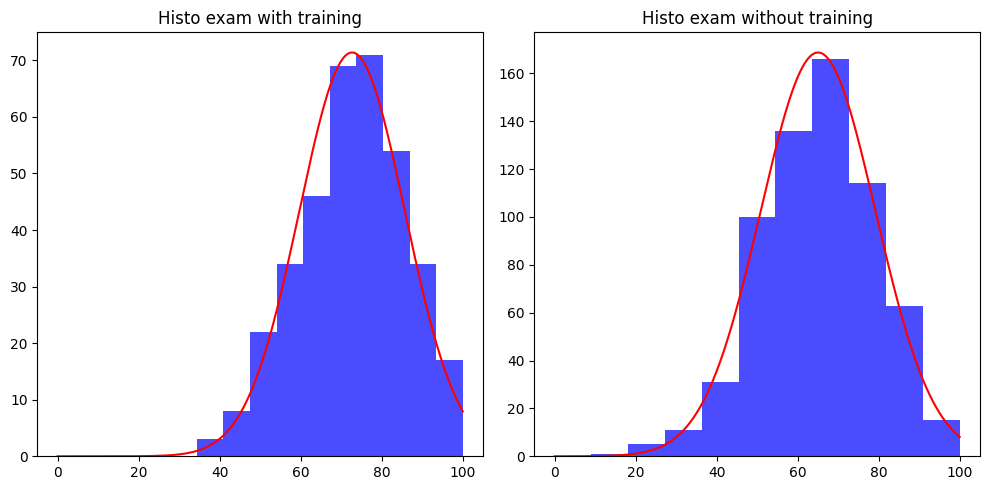

In [9]:
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1) 
plt.hist(bins1[:-1], bins1, weights=counts1, color='blue', alpha=0.7)
plt.plot(x1, normal_distrib1 * 2333, color="red")
plt.title('Histo exam with training')

plt.subplot(1, 2, 2)
plt.hist(bins2[:-1], bins2, weights=counts2, color='blue', alpha=0.7)
plt.plot(x2, normal_distrib2 * 6000, color="red")
plt.title('Histo exam without training')

plt.tight_layout()

plt.show()

Les données semblent suivre une distribution normale. Pour en être sûr, effectuons un test d'adéquation à la loi normale (test de Shapiro-Wilk) pour nos données.

In [10]:
_, p_value1 = shapiro(counts1)
_, p_value2 = shapiro(counts2)

p_value1, p_value2

(0.6168880462646484, 0.16210775077342987)

Les p-values sont supérieures à 0.05, nous n'avons donc pas assez de preuve pour rejeter l'hypothèse nulle. En prenant compte de l'allure des données, nous pouvons admettre que celles-ci suivent bien une distribution normale. Elles sont donc comparables.

Testons maintenant si le gain en moyenne est statistiquement significatif, par un test de t unilatéral à droite.

In [11]:
_, p_value = ttest_1samp(exam_with_training_score, exam_without_training_score.mean(), alternative='greater')

p_value

5.303292947477777e-25

La p-value est largement inférieure à 0.05 (5.3 * 10^-25), l'hypothèse nulle (H0) est donc rejetée ; le gain en moyenne est bien statistiquement significatif.

Testons également si la réduction de l'écart-type est statistiquement significatif, par un test de rapport de vraisemblance.

In [12]:
test_statistique = (len(exam_without_training_score) - 1) * (exam_without_training_score.std() ** 2) / (exam_with_training_score.std() ** 2)

ddl = len(exam_without_training_score) - 1 #deg de liberté

p_value = 1 - chi2.cdf(test_statistique, ddl)

p_value

0.0008675296702521651

La p-value est inférieure à 0.05 (8.6 * 10^-4), l'hypothèse nulle (H0) est donc rejetée ; la réduction de l'écart-type est bien statistiquement significative.

## V - Impact sur la cohérence des performances ##

Effectuons une visualisation comparative des distributions des performances avec et sans entraînement à l'aide de boîtes à moustaches (box plots). Cela permettra de visualiser graphiquement la réduction de l'écart-type et la cohérence accrue des performances parmi les étudiants formés.

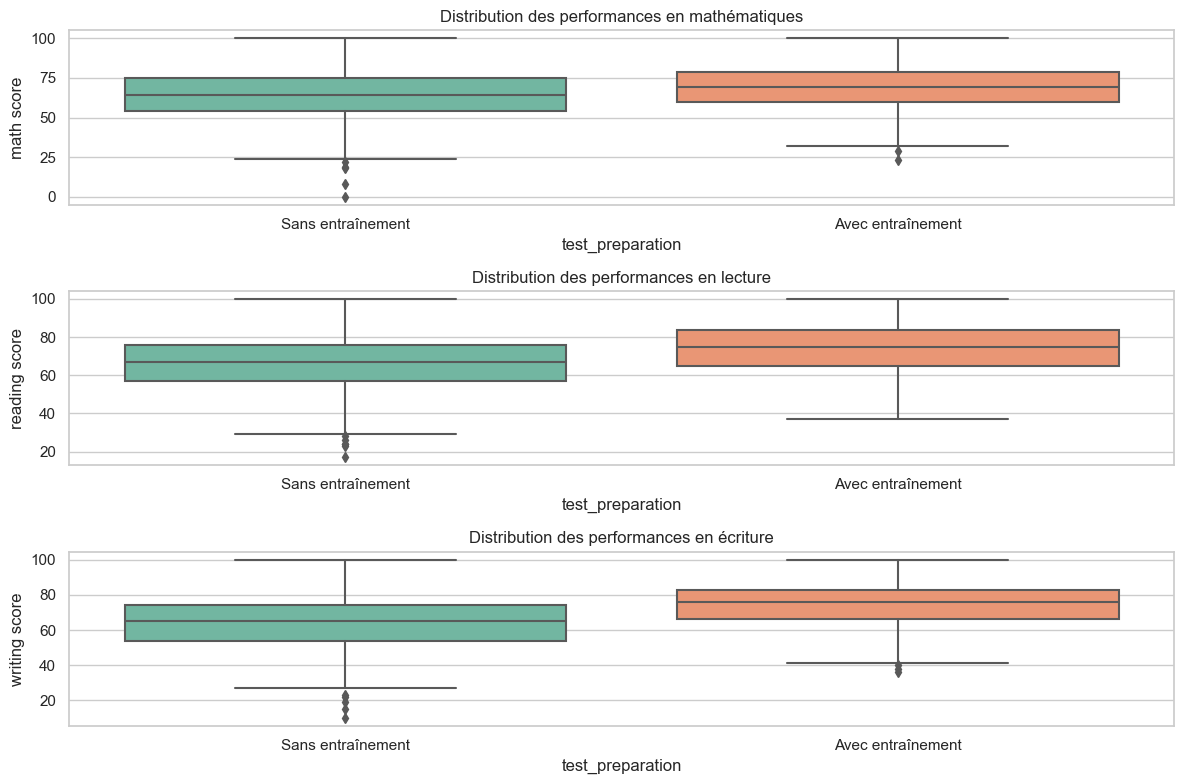

In [29]:
data = pd.read_csv(path)
data['test_preparation'] = data['test preparation course'].apply(lambda x: 'Avec entraînement' if x == 'completed' else 'Sans entraînement')
sns.set(style="whitegrid")
plt.figure(figsize=(12, 8))

# Box plot pour les performances en mathématiques avec et sans préparation
plt.subplot(3, 1, 1)
sns.boxplot(x='test_preparation', y='math score', data=data, palette='Set2')
plt.title('Distribution des performances en mathématiques')

# Box plot pour les performances en lecture avec et sans préparation
plt.subplot(3, 1, 2)
sns.boxplot(x='test_preparation', y='reading score', data=data, palette='Set2')
plt.title('Distribution des performances en lecture')

# Box plot pour les performances en écriture avec et sans préparation
plt.subplot(3, 1, 3)
sns.boxplot(x='test_preparation', y='writing score', data=data, palette='Set2')
plt.title('Distribution des performances en écriture')

plt.tight_layout()

plt.show()

En observant les boîtes à moustaches, nous pouvons voir que la boîte correspondant au groupe avec entraînement est plus resserrée, indiquant une dispersion plus faible des scores par rapport à la boîte du groupe sans entraînement et ce dans l'enesemble des matières.

In [14]:
cv_with_training = exam_with_training_score.std() / exam_with_training_score.mean()
cv_without_training = exam_without_training_score.std() / exam_without_training_score.mean()

cv_with_training, cv_without_training

(0.17940081377785566, 0.2181263515871492)

En examinant le coefficient de variation (CV), qui est le rapport de l'écart-type à la moyenne, nous obtenons des valeurs de 0.179 pour le groupe avec entraînement et de 0.218 pour le groupe sans entraînement. Un CV plus faible indique une plus grande cohérence des performances.

### Conclusion

On peut ainsi dire que l'analyse approfondie des données a révélé des insights significatifs quant à l'impact de la préparation à l'examen sur les performances des étudiants.
Les étudiants ayant suivi un entraînement ont montré une augmentation moyenne de 7.63 points dans leurs scores d'examens, une différence statistiquement significative confirmée par un test unilatéral. De plus, la réduction de l'écart-type suggère une plus grande cohérence des performances parmi les étudiants formés. Les distributions des données, évaluées par le test de Shapiro-Wilk, semblent suivre une distribution normale, renforçant la robustesse des résultats. Ainsi, cette analyse porte l'idée que la préparation à l'examen est associée à des performances améliorées de manière statistiquement significative, que ce soit en terme de moyenne ou de cohérence des résultats.